In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [57]:
df = pd.read_csv("data/Travel_Times - Paris.csv")
df.head()

,Origin Movement ID,Origin Display Name,Destination Movement ID,Destination Display Name,Date Range,Mean Travel Time (Seconds),Range - Lower Bound Travel Time (Seconds),Range - Upper Bound Travel Time (Seconds)
0,9,"Arc de triomphe du Carrousel, Paris",1,"0 Rue du Jour, Paris","09/03/2016 - 10/01/2016, Every day, Daily Average",446,229,866
1,9,"Arc de triomphe du Carrousel, Paris",2,"0 Rue du Louvre, Paris","09/03/2016 - 10/01/2016, Every day, Daily Average",291,159,529
2,9,"Arc de triomphe du Carrousel, Paris",3,"Impasse des 3 Visages, Paris","09/03/2016 - 10/01/2016, Every day, Daily Average",180,97,331
3,9,"Arc de triomphe du Carrousel, Paris",4,"0 Rue des Bourdonnais, Paris","09/03/2016 - 10/01/2016, Every day, Daily Average",169,67,422
4,9,"Arc de triomphe du Carrousel, Paris",5,"0 Quai des Orfèvres, Paris","09/03/2016 - 10/01/2016, Every day, Daily Average",426,204,889


In [58]:
df = df.rename(columns={
    "Origin Movement ID": "origin_move_id",
    "Origin Display Name": "origin_display_name",
    "Destination Display Name": "dest_display_name",
    "Destination Movement ID": "dest_move_id",
    "Date Range": "date_range",
    "Mean Travel Time (Seconds)": "avg_travel_time_sec",
    "Range - Lower Bound Travel Time (Seconds)": "lower_bound_time_sec",
    "Range - Upper Bound Travel Time (Seconds)": "upper_bound_time_sec"
})

In [59]:
df["dest_city"] = df["dest_display_name"].str.split(", ").str[1]

## Uncovering Estimated Time of Arrival: Travel Time Variability and Reliability in Urban Mobility

### Reliability and Risk Matrix

1. Which zones are unreliable?
- Compute Variability Index = (Upper - Lower) / Average
- Create a new column for route reliability:
  - Predictable: low avg time, low variability
  - Long: high avg time, low variability
  - Gamble: high variability, any time

In [60]:
df.dtypes

origin_move_id           int64
origin_display_name     object
dest_move_id             int64
dest_display_name       object
date_range              object
avg_travel_time_sec      int64
lower_bound_time_sec     int64
upper_bound_time_sec     int64
dest_city               object
dtype: object

In [61]:
# VI = (Upper Bound - Lower Bound) / Average
df["var_index"] = (df["upper_bound_time_sec"] - df["lower_bound_time_sec"]) / df["avg_travel_time_sec"]
df.sort_values(by="var_index", ascending=False)[["origin_move_id", "origin_display_name", "dest_move_id", "dest_display_name", "var_index"]].reset_index()

,index,origin_move_id,origin_display_name,dest_move_id,dest_display_name,var_index
0,9,9,"Arc de triomphe du Carrousel, Paris",11,"0 Quai de l'Horloge, Paris",2.850000
1,15,9,"Arc de triomphe du Carrousel, Paris",17,"100 Rue Saint Honoré, Paris",2.428571
2,3,9,"Arc de triomphe du Carrousel, Paris",4,"0 Rue des Bourdonnais, Paris",2.100592
3,11,9,"Arc de triomphe du Carrousel, Paris",13,"0 Rue de Richelieu, Paris-1ER-Arrondissement",2.076923
4,115,9,"Arc de triomphe du Carrousel, Paris",117,"0 Rue Bonaparte, Paris",2.072727
...,...,...,...,...,...,...
2222,1092,9,"Arc de triomphe du Carrousel, Paris",2299,"0 Avenue Marcelle, Sartrouville",0.324166
2223,1093,9,"Arc de triomphe du Carrousel, Paris",2302,"0 Rue Jean Mermoz, Sartrouville",0.321546
2224,1060,9,"Arc de triomphe du Carrousel, Paris",2049,"0 Avenue Madame de Sévigné, Maisons-Laffitte",0.308370
2225,1059,9,"Arc de triomphe du Carrousel, Paris",2046,"0 Avenue Carnot, Maisons-Laffitte",0.303993


The logic behind categorizing routes is following:
- Variability Index is the primary risk factor -> if a route exceedes the 75th percentile for variance it's flagged as risky.
- For the remaining stable routes, I segmented them by the median travel time

In [62]:
time_threshold = df["avg_travel_time_sec"].median()
var_threshold = df["var_index"].quantile(0.75)

def cat_route(row):
    if row["var_index"] > var_threshold:
        return "Risky"
    if row["avg_travel_time_sec"] > time_threshold:
        return "Long-Haul"
    else:
        return "Predictable"
    

df["route_predictability"] = df.apply(cat_route, axis=1)

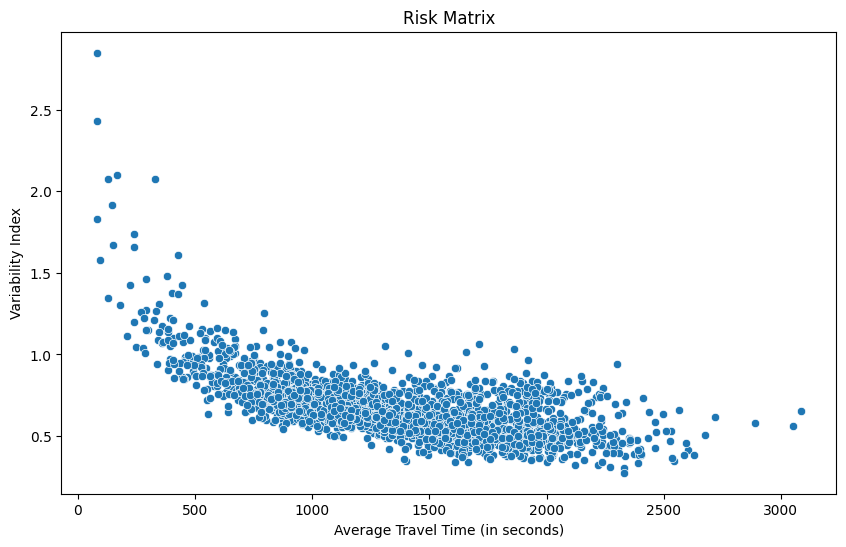

In [63]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="avg_travel_time_sec", y="var_index")
plt.title("Risk Matrix")
plt.xlabel("Average Travel Time (in seconds)")
plt.ylabel("Variability Index")
plt.show()

The shortest routes are more unpredictable, while the long ones are more realiable. The short routes look efficient but generate the most unpredictable user experience.
Optimising for only *average travel time* systematically hides risk on short routes.
ETA confidence should be a function of variability.
Long routes need fewer ETA buffers than short, central routes.

### Looking at the top 5 riskiest routes

In [64]:
high_uncertainty = df.groupby(["dest_move_id", "dest_display_name"])["var_index"].median().reset_index(name="var_index_med")

most_5_risky = high_uncertainty.sort_values(by="var_index_med", ascending=False).head(5)

In [65]:
pd.merge(most_5_risky, df, on=["dest_move_id", "dest_display_name"])[["dest_display_name", "avg_travel_time_sec", "var_index", "route_predictability"]]

,dest_display_name,avg_travel_time_sec,var_index,route_predictability
0,"0 Quai de l'Horloge, Paris",80,2.850000,Risky
1,"100 Rue Saint Honoré, Paris",84,2.428571,Risky
2,"0 Rue des Bourdonnais, Paris",169,2.100592,Risky
3,"0 Rue de Richelieu, Paris-1ER-Arrondissement",130,2.076923,Risky
4,"0 Rue Bonaparte, Paris",330,2.072727,Risky


The routes with low average travel time but high variability represent hidden risk. They appear efficient in aggregate metrcs, yet generate highest ETA errors.

Product Implications:
- Short routes need larger confidence buffers
- Show ETA ranges, not single numbers
- Driver incentives for "risky short routes"
- Warn users: "traffic conditions unstable"
- Reduce suprise cancellations

### Finding the Most Popular Routes
By popular here I mean routes that appear most often in db.

In [91]:
top_10_popular_cities = df.groupby("dest_city")["origin_move_id"].count().reset_index(name="route_counts").sort_values(by="route_counts", ascending=False).head(10)

In [92]:
top_10_popular_cities

,dest_city,route_counts
143,Paris,884
25,Boulogne-Billancourt,41
54,Courbevoie,31
185,Saint-Maur-des-Fossés,30
129,Nanterre,28
132,Neuilly-sur-Seine,26
6,Asnières-sur-Seine,25
105,Levallois-Perret,24
57,Créteil,23
49,Clichy,22


In [93]:
top_10_popular_cities

,dest_city,route_counts
143,Paris,884
25,Boulogne-Billancourt,41
54,Courbevoie,31
185,Saint-Maur-des-Fossés,30
129,Nanterre,28
132,Neuilly-sur-Seine,26
6,Asnières-sur-Seine,25
105,Levallois-Perret,24
57,Créteil,23
49,Clichy,22


In [94]:
cities_analysis = df.groupby("dest_city").agg(
    avg_tt=("avg_travel_time_sec", "mean"),
    med_var_index=("var_index", "median"),
).reset_index()

In [102]:
top_10_cities_analysis = cities_analysis[cities_analysis["dest_city"].isin(top_10_popular_cities.dest_city.values.tolist())]

In [103]:
for _, row in top_10_cities_analysis.iterrows():
    print(row["dest_city"])

Asnières-sur-Seine
Boulogne-Billancourt
Clichy
Courbevoie
Créteil
Levallois-Perret
Nanterre
Neuilly-sur-Seine
Paris
Saint-Maur-des-Fossés


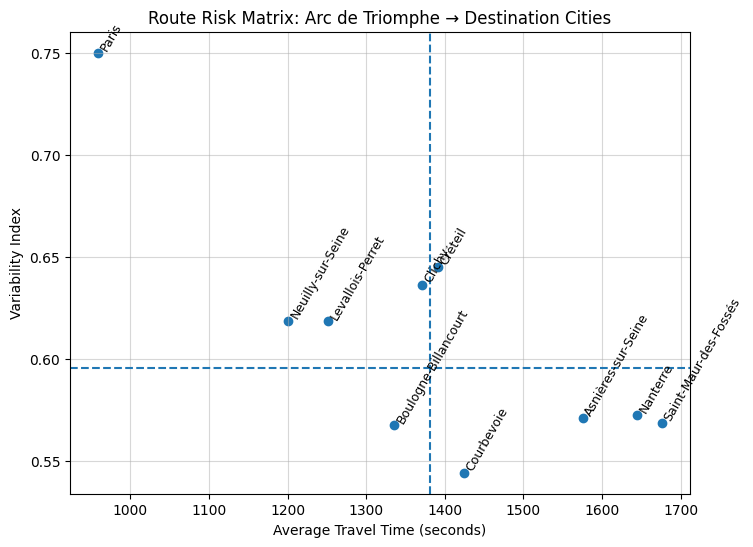

In [113]:
x_median = top_10_cities_analysis["avg_tt"].median()
y_median = top_10_cities_analysis["med_var_index"].median()

plt.figure(figsize=(8, 6))

plt.scatter(top_10_cities_analysis["avg_tt"], top_10_cities_analysis["med_var_index"])

for _, row in top_10_cities_analysis.iterrows():
    plt.text(
        row["avg_tt"],
        row["med_var_index"],
        row["dest_city"],
        fontsize=9,
        ha="left",
        va="bottom",\
        rotation=60
    )

plt.axvline(x_median, linestyle="--")
plt.axhline(y_median, linestyle="--")

plt.xlabel("Average Travel Time (seconds)")
plt.ylabel("Variability Index")
plt.title("Route Risk Matrix: Arc de Triomphe → Destination Cities")
plt.grid(alpha=0.5)

plt.show()


Each point represents a destination city. The x-axis shows cost in time, the y-axis shows reliability risk. The dashed lines split destinations into fast vs slow and reliable vs volatile routes.

Insights:
- Paris -> fast but risky
- Nanterre / Saint-Maur -> slow but predictable
- Courbevoie / Boulogne -> middle-ground tradeoffs